In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
print(dl.inpath)
print(dl.outpath)

from asap.data import sim

N=1000
P=2000
K=10

H = sim.generate_H(N, K)
W = sim.generate_W(P, K)
R = np.matmul(H, W.T) 
X = np.random.poisson(R)

dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
from asap.annotation import ASAPNMF
import asapc 

asap = ASAPNMF(adata=dl)
asap.get_pbulk()
asap.pbulk_mat.shape

(419, 2000)

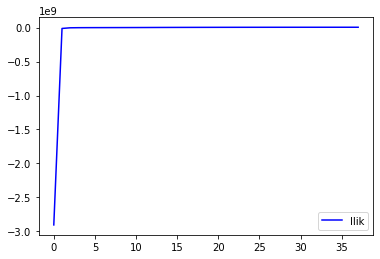

In [4]:
K = 10
nmf_model = asapc.ASAPdcNMF(asap.pbulk_mat.T,K)
nmf = nmf_model.nmf()

regm = asapc.ASAPdcNMFPredict(dl.mtx.T,nmf.beta_a,nmf.beta_b)
reg = regm.predict()

plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

In [8]:
beta = nmf.beta
theta = reg.theta
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(theta)
df_theta.index = dl.rows


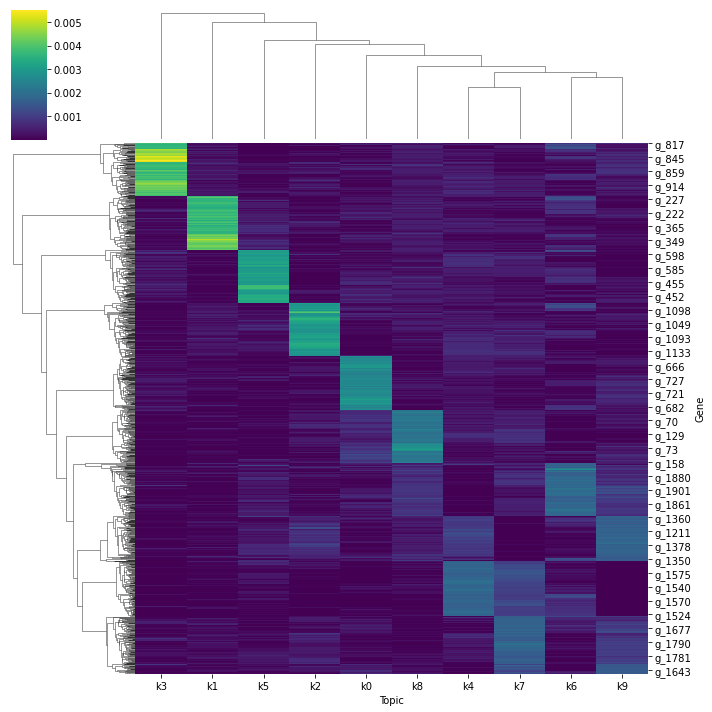

In [9]:

df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [10]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,c_0,0,4.357943,3.345798
1,c_1,5,4.416337,6.153316
2,c_2,7,7.917474,4.602015
3,c_3,0,5.253257,2.497242
4,c_4,0,8.515039,4.203022
...,...,...,...,...
995,c_995,4,3.345417,2.348087
996,c_996,9,7.801037,2.075476
997,c_997,7,8.975470,2.583306
998,c_998,0,5.354647,2.889138


Text(0, 0.5, 'UMAP2')

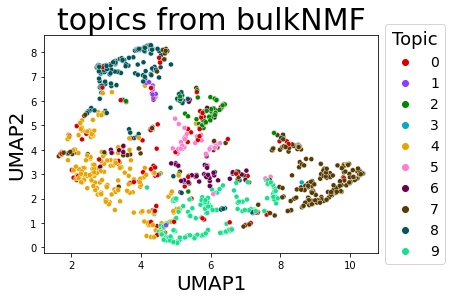

In [11]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)